In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn import preprocessing

from scipy.stats import skew
import scipy.stats as st

%matplotlib inline

In [2]:
#import train and test dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Train shape: (1460, 81)
Test shape: (1459, 80)


In [3]:
df_all = pd.concat([train.drop(columns=['SalePrice', 'Id']), test.drop(columns='Id')])
print(f'Concated shape: {df_all.shape}')

Concated shape: (2919, 79)


In [4]:
df_all.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


### Treat Missing Value 

<AxesSubplot:>

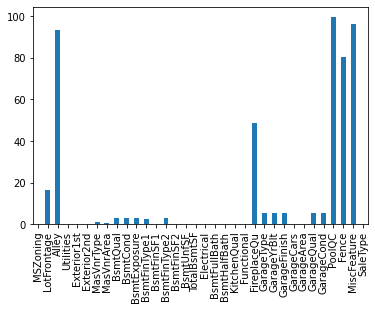

In [5]:
# Missing Value
null_sum = df_all.isnull().sum()
(null_sum[null_sum > 0]/(df_all.shape[0])*100).plot.bar()

In [6]:
# Removing missing value more than 20%
null_perc = (null_sum[null_sum > 0]/(df_all.shape[0])*100)
print(null_perc[null_perc>20].index)
df_all = df_all.drop(columns=null_perc[null_perc>20].index)

Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')


In [7]:
null_columns = list(null_perc[null_perc<=20].index)
print(null_columns)

['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'SaleType']


In [8]:
for c in null_columns:
    if df_all[c].dtype == 'object':
        df_all[c] = df_all[[c]].replace(np.NAN, df_all[c].mode()[0])
    else:
        df_all[c] = df_all[c].replace(np.NAN, df_all[c].mean())
        
print(df_all.isnull().sum()[df_all.isnull().sum() > 0])

Series([], dtype: int64)


In [9]:
#Quantitative and Qualitative features
quantitative = [f for f in df_all.columns if df_all.dtypes[f] != 'object']
qualitative = [f for f in df_all.columns if df_all.dtypes[f] == 'object']

In [10]:
# Qualitative Features
print(f'Qualitative features : {qualitative}')

Qualitative features : ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [11]:
# Quantitative Features
print(f'Quantitative features : {quantitative}')

Quantitative features : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


### Simplifying Qualitative Features
1. ExterQual
2. ExterCond
3. BsmtQual
4. BsmtCond
5. BsmtExposure
6. BsmtFinType1
7. BsmtFinType2
8. HeatingQC
9. FirePlaceQu (Dropped)
10. GarageFinish
11. GarageCond 
12. PavedDrive
13. PoolQC (Dropped)
14. Fence (Dropped)

Qualitative features : ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']

In [12]:
sim_qual = ['BsmtFinType1','BsmtFinType2','ExterQual','ExterCond','BsmtQual','BsmtCond',
            'HeatingQC','KitchenQual','GarageCond','GarageQual','GarageFinish', 'BsmtExposure','PavedDrive']

In [13]:
count = 0
for c in sim_qual:
    if (count<2):
        df_all[c] = df_all[c].replace(dict(GLQ=6, ALQ=5, BLQ=4, Rec=3, LwQ=2, Unf=1, NA=0))
    if (count>=2 and count<10):
        df_all[c] = df_all[c].replace(dict(Ex=5, Gd=4, TA=3, Fa=2, Po=1, NA=0))
    if (count == 10):
        df_all[c] = df_all[c].replace(dict(Fin=3, RFn=2, Unf=1, NA=0))
    if (count == 11):
        df_all[c] = df_all[c].replace(dict(Gd=4, Av=3, Mn=2, No=1, NA=0))
    if (count == 12):
        df_all[c] = df_all[c].replace(dict(Y=2, P=1, N=0))
    print(f'count: {count} ---- Simplified feature : {c}')
    count+=1
    

count: 0 ---- Simplified feature : BsmtFinType1
count: 1 ---- Simplified feature : BsmtFinType2
count: 2 ---- Simplified feature : ExterQual
count: 3 ---- Simplified feature : ExterCond
count: 4 ---- Simplified feature : BsmtQual
count: 5 ---- Simplified feature : BsmtCond
count: 6 ---- Simplified feature : HeatingQC
count: 7 ---- Simplified feature : KitchenQual
count: 8 ---- Simplified feature : GarageCond
count: 9 ---- Simplified feature : GarageQual
count: 10 ---- Simplified feature : GarageFinish
count: 11 ---- Simplified feature : BsmtExposure
count: 12 ---- Simplified feature : PavedDrive


In [14]:
df_all[sim_qual].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   BsmtFinType1  2919 non-null   int64
 1   BsmtFinType2  2919 non-null   int64
 2   ExterQual     2919 non-null   int64
 3   ExterCond     2919 non-null   int64
 4   BsmtQual      2919 non-null   int64
 5   BsmtCond      2919 non-null   int64
 6   HeatingQC     2919 non-null   int64
 7   KitchenQual   2919 non-null   int64
 8   GarageCond    2919 non-null   int64
 9   GarageQual    2919 non-null   int64
 10  GarageFinish  2919 non-null   int64
 11  BsmtExposure  2919 non-null   int64
 12  PavedDrive    2919 non-null   int64
dtypes: int64(13)
memory usage: 319.3 KB


### Binning Year Features 
1. YearBuilt
2. YearRemodAdd
3. YrSold
4. GarageYrBlt

In [15]:
#Binning the YearBuilt, YearRemodAdd, YrSold and GarageYrBlt
col = ['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt']
for c in col:
    df_all[c] = pd.qcut(df_all[c], 10, duplicates='drop')
    
#Encode categorical features to numeric feature
for c in col:
    df_all[c] = preprocessing.LabelEncoder().fit_transform(df_all[c].values)

In [16]:
#     Check values
df_all[col] = df_all[col]
df_all[col].head()

,YearBuilt,YearRemodAdd,YrSold,GarageYrBlt
0,7,6,1,7
1,5,2,0,4
2,7,5,1,7
3,0,1,0,6
4,7,5,1,7


### Creating New Features

In [17]:
#Total Lot Area
df_all['TotalLot'] = df_all['LotFrontage'] + df_all['LotArea']

#Total number of basement bathroom
df_all['BsmtBath'] = df_all['BsmtFullBath'] + df_all['BsmtHalfBath']

#Total number of bathroom above grade
df_all['Bath'] = df_all['FullBath'] + df_all['HalfBath']

#Total number of bathroom
df_all['TotalBath'] = (df_all['FullBath'] + 0.5*df_all['HalfBath'] + 
                        df_all['BsmtFullBath'] + 0.5*df_all['BsmtHalfBath'])

#Total Finished Square Feet Above Grade
df_all['FloorFinSF'] = df_all['1stFlrSF'] + df_all['2ndFlrSF']

#Total Finished Squared feet
df_all['TotalFinSF'] = df_all['BsmtFinSF1'] + df_all['BsmtFinSF2'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']

#Total Basement Unfinish SF and Low Quality Finished SF
df_all['Total_BsmtUnfSf_LowQualFinSF'] = df_all['BsmtUnfSF'] + df_all['LowQualFinSF']

#Total Porch SF
df_all['TotalPorchSF'] = (df_all['OpenPorchSF'] + df_all['3SsnPorch'] + df_all['EnclosedPorch'] 
                            + df_all['ScreenPorch'] + df_all['WoodDeckSF'])

In [18]:
#Garage
df_all['GarageArea'] = df_all['GarageArea'].apply(lambda x: 1 if x>0 else 0)

#Pool
df_all['PoolArea'] = df_all['PoolArea'].apply(lambda x: 1 if x>0 else 0)

In [19]:
#Ratio of Low Quality Squared Feet to Total Finished Square Feet Above Grade
df_all['R_LowQual_FloorFinSF'] = df_all['LowQualFinSF'] / df_all['FloorFinSF']

#Ratio of Basement Unfinished Squared Feet to Total Basement Squared feet
df_all['R_BsmtUnfSF_TotalBsmtSF'] = df_all['BsmtUnfSF'] / df_all['TotalBsmtSF']

#Cars per Garage Area
df_all['CarPerGarageArea'] = df_all['GarageCars'] / df_all['GarageArea']

#Ratio of Total Finished Square Feet Above Grade to 
df_all['R_FloorFinSF_'] = df_all['FloorFinSF'] / df_all['BedroomAbvGr']

In [20]:
#Overall House Quality and Condition Score
df_all['OverallScore'] = 0.5*df_all['OverallCond'] + 0.5*df_all['OverallQual']

#Overall Kitchen Score 
df_all['KitchenScore'] = df_all['KitchenAbvGr'] * df_all['KitchenQual']

#Overall Exter Score
df_all['ExterScore'] = df_all['ExterCond'] * df_all['ExterQual']

#Basement Finished Type Score
df_all['BsmtFinTypeScore'] = df_all['BsmtFinType1'] * df_all['BsmtFinType2']

#Overall Basement SF Score
df_all['BsmtScore'] = (df_all['BsmtFinTypeScore'] + df_all['BsmtQual'] + df_all['BsmtCond'] 
                       + df_all['BsmtExposure'] * (1-df_all['R_BsmtUnfSF_TotalBsmtSF']))

#Overall Finished SF Score
df_all['FinSFScore'] = df_all['FloorFinSF'] * (1-df_all['R_LowQual_FloorFinSF'])

#Overall Garage Score
df_all['GarageScore'] = df_all['GarageQual'] * df_all['GarageCond']


### SalePrice Correlation

In [21]:
quantitative = [f for f in df_all.columns if df_all.dtypes[f] != 'object']
print(quantitative)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'TotalLot', 'BsmtBath', 'Bath', 'TotalBath', 'FloorFinSF', 'TotalFinSF', 'Total_BsmtUnfSf_LowQualFinSF', 'TotalPorchSF', 'R_LowQual_FloorFinSF', 'R_BsmtUnfSF_TotalBsmtSF', 'CarPerGarageArea', 'R_FloorFinSF_', 'OverallScore', 'KitchenScore', 'ExterScore', 'BsmtFinTypeScore', 'BsmtScore', 'FinSFScore', 'GarageScore'

In [22]:
corr = df_all[:1460]
corr = pd.concat([train['SalePrice'], corr[quantitative]], axis=1)
corr

,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,R_BsmtUnfSF_TotalBsmtSF,CarPerGarageArea,R_FloorFinSF_,OverallScore,KitchenScore,ExterScore,BsmtFinTypeScore,BsmtScore,FinSFScore,GarageScore
0,208500,60,65.0,8450,7,5,7,6,196.0,4,...,0.175234,2.0,570.000000,6.0,4,12,6,13.824766,1710.0,9
1,181500,20,80.0,9600,6,8,5,2,0.0,3,...,0.225040,2.0,420.666667,7.0,3,9,5,15.099842,1262.0,9
2,223500,60,68.0,11250,7,5,7,5,162.0,4,...,0.471739,2.0,595.333333,6.0,4,12,6,14.056522,1786.0,9
3,140000,70,60.0,9550,7,5,0,1,0.0,3,...,0.714286,3.0,572.333333,6.0,4,9,5,12.285714,1717.0,9
4,250000,60,84.0,14260,8,5,7,5,350.0,4,...,0.427948,3.0,549.500000,6.5,4,12,6,14.716157,2198.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,175000,60,62.0,7917,6,5,7,5,0.0,3,...,1.000000,2.0,549.000000,5.5,3,9,1,8.000000,1647.0,9
1456,210000,20,85.0,13175,6,6,5,3,119.0,3,...,0.381971,2.0,691.000000,6.0,3,9,15,22.618029,2073.0,9
1457,266500,70,66.0,9042,7,9,1,7,0.0,5,...,0.761285,1.0,585.000000,8.0,4,20,6,13.238715,2340.0,9
1458,142125,20,68.0,9717,5,6,2,4,0.0,3,...,0.000000,1.0,539.000000,5.5,4,9,18,26.000000,1078.0,9


In [23]:
corr = corr.corr()
corr.SalePrice.sort_values(ascending=False).head(11)

SalePrice           1.000000
OverallQual         0.790982
FinSFScore          0.718994
FloorFinSF          0.716883
GrLivArea           0.708624
TotalFinSF          0.708047
ExterQual           0.682639
KitchenQual         0.659600
BsmtQual            0.650138
GarageCars          0.640409
CarPerGarageArea    0.637095
Name: SalePrice, dtype: float64

### Creating New Polynomial Features (Top10)

In [24]:
# top10 = corr.SalePrice.sort_values(ascending=False).index[:10]
# print(f'Total features before creating polynomial features: {df_all.shape[1]}')
# for c in top10[1:]:
#     df_all[c + '_s2'] = df_all[c] ** 2
#     df_all[c + '_s3'] = df_all[c] ** 3
#     df_all[c + '_sqrt'] = np.sqrt(df_all[c])
# #     df_all[c + '_cbrt'] = np.cbrt(df_all[c])

# print(f'Total features after creating polynomial features: {df_all.shape[1]}')

### Return Value Features to Train Dataset 

In [25]:
y = np.log1p(train.SalePrice)

In [26]:
train = pd.concat([train['Id'],y, df_all[:1460]], axis=1)
print(train.shape)

(1460, 95)


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 95 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            1460 non-null   int64  
 1   SalePrice                     1460 non-null   float64
 2   MSSubClass                    1460 non-null   int64  
 3   MSZoning                      1460 non-null   object 
 4   LotFrontage                   1460 non-null   float64
 5   LotArea                       1460 non-null   int64  
 6   Street                        1460 non-null   object 
 7   LotShape                      1460 non-null   object 
 8   LandContour                   1460 non-null   object 
 9   Utilities                     1460 non-null   object 
 10  LotConfig                     1460 non-null   object 
 11  LandSlope                     1460 non-null   object 
 12  Neighborhood                  1460 non-null   object 
 13  Con

### Removing Outliers (Cheap and Expensive House)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

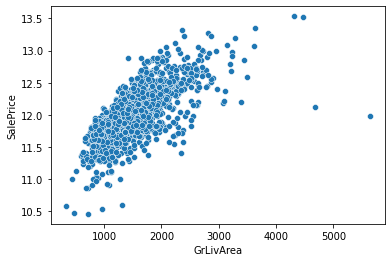

In [28]:
sns.scatterplot(data=train, x='GrLivArea', y='SalePrice')

In [29]:
train = train[train.GrLivArea<4000]
train = train[train.SalePrice>10.75]

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

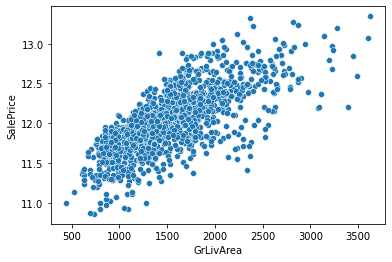

In [30]:
sns.scatterplot(data=train, x='GrLivArea', y='SalePrice')

In [31]:
y = train.SalePrice
train = train.drop(columns=['Id', 'SalePrice'])
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,R_BsmtUnfSF_TotalBsmtSF,CarPerGarageArea,R_FloorFinSF_,OverallScore,KitchenScore,ExterScore,BsmtFinTypeScore,BsmtScore,FinSFScore,GarageScore
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.175234,2.0,570.000000,6.0,4,12,6,13.824766,1710.0,9
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0.225040,2.0,420.666667,7.0,3,9,5,15.099842,1262.0,9
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0.471739,2.0,595.333333,6.0,4,12,6,14.056522,1786.0,9
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0.714286,3.0,572.333333,6.0,4,9,5,12.285714,1717.0,9
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0.427948,3.0,549.500000,6.5,4,12,6,14.716157,2198.0,9


In [32]:
train.shape

(1451, 93)

### Skew Features 

In [33]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
print(f'Quantitative features: {quantitative}, Total: {len(quantitative)}')

Quantitative features: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'TotalLot', 'BsmtBath', 'Bath', 'TotalBath', 'FloorFinSF', 'TotalFinSF', 'Total_BsmtUnfSf_LowQualFinSF', 'TotalPorchSF', 'R_LowQual_FloorFinSF', 'R_BsmtUnfSF_TotalBsmtSF', 'CarPerGarageArea', 'R_FloorFinSF_', 'OverallScore', 'KitchenScore', 'ExterScore', 'BsmtFinTypeScore', 'BsmtScore', 'Fin

In [34]:
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']
print(f'Quantitative features: {qualitative}, Total: {len(qualitative)}')

Quantitative features: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'SaleType', 'SaleCondition'], Total: 25


In [35]:
n = train.isnull().sum()
n = n[n>0]
print(f'Null found:\n{n}')

Null found:
R_BsmtUnfSF_TotalBsmtSF    36
CarPerGarageArea           78
BsmtScore                  36
dtype: int64


In [36]:
train = train.fillna(0)
n = train.isnull().sum()
n = n[n>0]
print(f'Null found:\n{n}')

Null found:
Series([], dtype: int64)


In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 0 to 1459
Data columns (total 93 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   MSSubClass                    1451 non-null   int64  
 1   MSZoning                      1451 non-null   object 
 2   LotFrontage                   1451 non-null   float64
 3   LotArea                       1451 non-null   int64  
 4   Street                        1451 non-null   object 
 5   LotShape                      1451 non-null   object 
 6   LandContour                   1451 non-null   object 
 7   Utilities                     1451 non-null   object 
 8   LotConfig                     1451 non-null   object 
 9   LandSlope                     1451 non-null   object 
 10  Neighborhood                  1451 non-null   object 
 11  Condition1                    1451 non-null   object 
 12  Condition2                    1451 non-null   object 
 13  Bld

In [38]:
skewness = train[quantitative].apply(lambda x: skew(x))

/Users/wongxingyik/Desktop/Kaggle_house_price/lib/python3.9/site-packages/scipy/stats/stats.py:951: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


In [39]:
skewness = skewness[abs(skewness) > 0.5]
print(skewness.sort_values(ascending=False))

MiscVal                         24.376280
PoolArea                        16.947078
LotArea                         12.558211
TotalLot                        12.543299
R_LowQual_FloorFinSF            10.708510
3SsnPorch                       10.261120
LowQualFinSF                     8.973279
KitchenAbvGr                     4.467938
BsmtFinSF2                       4.235845
BsmtHalfBath                     4.116420
ScreenPorch                      4.103163
BsmtFinType2                     3.528602
EnclosedPorch                    3.097267
MasVnrArea                       2.648242
BsmtFinTypeScore                 2.395690
OpenPorchSF                      2.201245
GarageScore                      1.760366
LotFrontage                      1.699468
WoodDeckSF                       1.545219
ExterCond                        1.444645
MSSubClass                       1.401925
KitchenScore                     1.293245
BsmtExposure                     1.223521
BsmtScore                        1

In [40]:
# sns.histplot(x=df_all['GarageCond'])

In [41]:
train[skewness.index] = np.log1p(train[skewness.index])

### Create Dummy Features

In [42]:
# Qualitative Features

# # "Electrical" features
# df_all['Electrical'].loc[df_all['Electrical']=='Mix'] = 'SBrkr'
# # "Exterior2nd" features
# df_all['Exterior2nd'].loc[df_all['Exterior2nd']=='Other'] = 'VinylSd'
# # "Heating" features
# df_all['Heating'].loc[df_all['Heating']=='OthW'] = 'GasA'
# df_all['Heating'].loc[df_all['Heating']=='Floor'] = 'GasA'
# # "HouseStyle" features
# df_all['HouseStyle'].loc[df_all['HouseStyle']=='2.5Fin'] = '1.5Fin'

In [43]:
#Using One Hot Encoding
print(f'Total features before creating dummy features: {train.shape[1]}')
train = pd.get_dummies(train, columns=qualitative)
print(f'Total features after creating dummy features: {train.shape[1]}')


Total features before creating dummy features: 93
Total features after creating dummy features: 243


# ElasticNetCV

In [44]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.30, random_state=0)
print(f'X_train : {X_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')

X_train : (1015, 243)
X_test : (436, 243)
y_train : (1015,)
y_test : (436,)


In [45]:
# Standardize numerical features
stdSc = StandardScaler()
X_train = pd.DataFrame(stdSc.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(stdSc.transform(X_test), columns=X_test.columns, index=X_test.index)

ValueError: Input contains infinity or a value too large for dtype('float64').

In [ ]:
X_train.head()

In [ ]:
X_test.head()

In [ ]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [ ]:
# 4* ElasticNet
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)

In [ ]:
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

In [ ]:
print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)

In [ ]:
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

In [ ]:
print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

In [ ]:
print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

In [ ]:
test_pred = elasticNet.predict(test)
test_pred = np.expm1(test_pred)
submission = pd.concat([pd.read_csv('test.csv').Id, pd.DataFrame(test_pred, columns=['SalePrice'])], axis=1)
submission.head()


In [ ]:
submission.to_csv('Aug16_v3.csv',index=False)